# COMENTARIOS

* En este dataset se busca info con personas. Por eso, se pierden las filas donde hay problemas con la persona
* Ver si corrijo el calculo de las columnas de tipo float

# Información 

1. Descricpción del problema
1. Data cleaning 
1. Data formatting
1. EDA
3. Feature selecction y engenieering
4. Comparación de modelos
5. Hyperparameter tunning sobre el mejor modelo
6. Evaluacion
7. Interpretación
8. Conclusión

OBJETIVO: Determinar que personas van a ser morosos en los prestamos

# 0. IMPORTACIONES Y SETEOS

## Imports 

In [1]:
# Pandas y numpy para manipulación
import pandas as pd
import numpy as np
# Librerias para gráficos 
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones de DS
import DSImplementation as dsimp
# Funciones para analizar valores faltantes 
import missingno as msno

## Seteos

In [2]:
# Para evitar que salgan advertencias por usar dataframes sin un .copy()
pd.options.mode.chained_assignment = None

# Se setea un maximo de 60 columnas para visualizar
pd.set_option('display.max_columns', 60)

# Matplotlib visualización en la celda
%matplotlib inline

# Ver con dos decimales los float
pd.options.display.float_format = "{:,.2f}".format


# 1. DESCRIPCIÓN DEL PROBLEMA 

* Fecha_Pago: fecha cuando la persona pago la cuota del prestamo. Es diferente a la fecha de acreditación. 
* Vencimiento: fecha en la cual vence el prestamos, y hay algunos prestamos con doble fecha de vencimiento. El primer vencimiento es siempre el 20 y el segundo es el 30. No todos los tipos de linea de prestamos admiten segundo vencimiento. 
* Tipo de prestamo: numero de ID, cada ID corresponde a un barrio diferente. El IVC construye de a un barrio por vez. Puede pasar que para un mismo barrio puedo tener diferentes tipo de prestamo (linea de prestamo). 
* Numero_Prestamo: Es el ID del prestamo. Es unico y no se repite
* Total_prestamo[CALCULADO]: el total que tiene que pagar para el prestamos, no es lo que le falta. Se calcula como suma de capital, interes y gastos.
* Total_cutas: cantidad de cuotas que tiene el prestamo
* Numero de cuota: es la cuota que se esta pagando. Se permite saltear cuotas, es decir, se puede no pagar la 16 y pagar la 17. De esta forma la persona quedaria adeudnado la cuota 16.
* Pago: monto del recibo de pago. Cada pago puede no corresponder a una unica cuota. Puede ser una de cuatro opciones: Pago de cuota completa, pago parcial de cuota, adelanto de cuota, pago completo del prestamo. 
* Genero: Masculino o Femenino, binario
* Edad[CALCULADO]: la edad del que pide el prestamo
* Paga_en_termino [CALCULADO]: si pago antes del vencimiento. A partir de 2021 se introdujo segundo vencimiento (el 30). 1 es que esta en termino, 0 que no pago en termino
* Refinaciado [CALCULADO] : indica si el prestamo fue refinanciado en el pasado. Es decir, cuando se reestructura la deuda. 1 es que esta refinanciado, 0 que no esta refinanciado. 


Nuestro campo targe es "Pagado en termino" para evaluar si el mes que viene me van a pagar o no 

Columnas a agregar:

* Numerico indicando tipo de pago. 1: Pago de cuota completa, 2: pago parcial de cuota, 3: adelanto de cuota, 4: pago completo del prestamo
* Faltante total a pagar: el monto que falta pagar del prestamo

Preguntas:

* Agrego columnas que traiga cantidad de cuotas no pagas en terminas para ese prestamo por esa persona?


# 2. DATA CLEANING

## Carga del dataset a trabajar 

In [3]:
# Se carga el dataset
df = pd.read_csv('Data/DATASET TP4 VERSION 7 2015-2019 correjido.csv', sep=';')
df.head(5)

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
0,02/01/2015,20/02/2015,974,1091205,"16,090,435.00","181874,40",240,119,"0,50","623,82","0,34",Masculino,42.00,1,0
1,02/01/2015,20/01/2015,974,1091205,"16,090,435.00","181874,40",240,118,"0,51","623,82","0,34",Masculino,42.00,1,0
2,02/01/2015,20/03/2015,974,1091205,"16,090,435.00","181874,40",240,120,"0,50","623,82","0,34",Masculino,42.00,1,0
3,02/01/2015,20/01/2015,955,1095467,"2,115,837.00","14180,19",360,102,"0,72","45,26","0,32",Femenino,95.00,1,0
4,02/01/2015,20/02/2015,877,10991758,"25,238,393.00","551452,31",360,45,"0,88","993,63","0,18",NaN,45.00,1,0


In [4]:
# Unifico nombre de columnas
columns_names_new = list(map(lambda x: x.lower(), df.columns))
df.columns = columns_names_new
df.head()

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado
0,02/01/2015,20/02/2015,974,1091205,"16,090,435.00","181874,40",240,119,"0,50","623,82","0,34",Masculino,42.00,1,0
1,02/01/2015,20/01/2015,974,1091205,"16,090,435.00","181874,40",240,118,"0,51","623,82","0,34",Masculino,42.00,1,0
2,02/01/2015,20/03/2015,974,1091205,"16,090,435.00","181874,40",240,120,"0,50","623,82","0,34",Masculino,42.00,1,0
3,02/01/2015,20/01/2015,955,1095467,"2,115,837.00","14180,19",360,102,"0,72","45,26","0,32",Femenino,95.00,1,0
4,02/01/2015,20/02/2015,877,10991758,"25,238,393.00","551452,31",360,45,"0,88","993,63","0,18",NaN,45.00,1,0


## Tipo de datos, valores faltantes y valores nulos 

In [5]:
# Cantidad de datos totales
rows_n, cols_n = df.shape
print(rows_n, cols_n)

763877 15


### Valores nulos y tipo de datos 

In [6]:
# Se observa los tipos de columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763877 entries, 0 to 763876
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   fecha_pago                          763877 non-null  object 
 1   vencimiento                         763877 non-null  object 
 2   tipo_prestamo                       763877 non-null  int64  
 3   numero_prestamo                     763877 non-null  int64  
 4   dni                                 649441 non-null  float64
 5   total_prestamo                      763877 non-null  object 
 6   total_cuotas                        763877 non-null  int64  
 7   numero_cuota                        763877 non-null  int64  
 8   porcentaje_de_cuotas_faltantes      763877 non-null  object 
 9   pago                                763877 non-null  object 
 10  porcentaje_de_cuota_sobre_prestamo  763877 non-null  object 
 11  genero                    

In [7]:
# Detectamos valores faltantes en genero
dsimp.missing_values_table(df)

Your selected dataframe has 15 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
genero,326688,42.80
edad,299550,39.20
dni,114436,15.00


Detectamos Valores faltantes en GENERO; EDAD Y DNI

<AxesSubplot:>

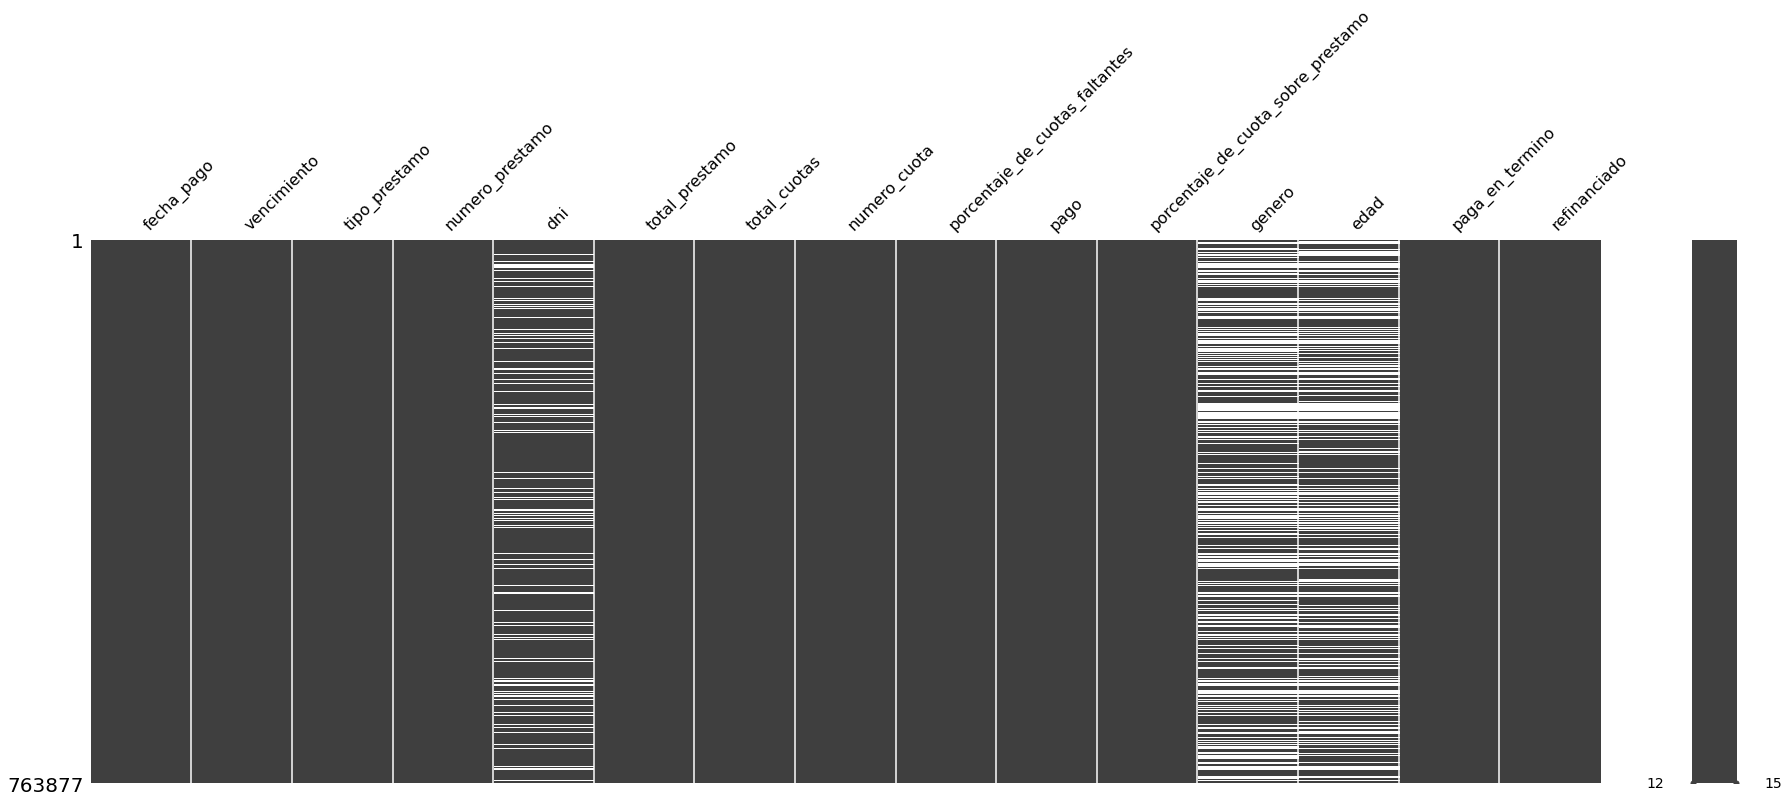

In [8]:
# Detectamos valores faltantes
msno.matrix(df, figsize=(30,10))

## Chequeo que para cada DNI exista una unica edad y genero

In [9]:
dni_df = df[['dni', 'edad', 'genero']]

In [10]:
dni_uniques = dni_df.groupby('dni')['edad','genero'].nunique()
dni_uniques.head(3)

C:\Users\Fran\AppData\Local\Temp/ipykernel_10668/2013069165.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dni_uniques = dni_df.groupby('dni')['edad','genero'].nunique()


,edad,genero
dni,,
2.00,0,0
9.00,1,1
29.00,1,1


In [11]:
# Obtengo los DNI que tengan mas de una edad o genero
dni_error = dni_uniques[(dni_uniques>1).any(axis=1)].index
dni_error

Float64Index([ 3073270.0,  4305479.0,  4954272.0,  4991124.0,  5087952.0,
               5124029.0,  5138405.0,  5201050.0,  5282162.0,  5570811.0,
               5594257.0,  5658001.0,  5665791.0,  6084686.0,  6147893.0,
               6245394.0,  6371629.0,  6519814.0,  6536437.0,  6652650.0,
               7162249.0,  7377515.0,  7704965.0,  8252165.0,  8326485.0,
               8400924.0,  8514256.0,  8633243.0, 10174146.0, 10758672.0,
              11241030.0, 11469042.0, 11768623.0, 12702446.0, 12712566.0,
              13285676.0, 14317845.0, 16051677.0, 16315055.0, 16938614.0,
              17046748.0, 17187923.0, 17283305.0, 17563244.0, 17614252.0,
              18328611.0, 18387076.0, 18404973.0, 18652869.0, 20351439.0,
              20389809.0, 20986191.0, 21640157.0, 24905162.0, 25228398.0,
              92028416.0, 92089425.0, 92099674.0, 92244256.0, 92452663.0,
              92640824.0, 92676137.0, 92840561.0, 92903683.0, 92940304.0,
              92947290.0, 92950018.0, 

In [12]:
df_1_sin_dni_error = df[~df['dni'].isin(dni_error)].copy()

### Genero y edad 

In [13]:
# Separado las columnas que no tienen problemas de las que si
columns_problem = ['genero', 'edad']
columns_ok = list(set(df.columns) - set(columns_problem))

In [14]:
#  Chequeo filas duplicadas del dataset, habiendo sacado las columnas de genero y edad
df_1_sin_dni_error[columns_ok].duplicated().sum()

65590

In [15]:
# Mergeo las filas duplicadas remplazando los valores nulos de genero y edad // ver si las droppeo los prestamos
df_2_sin_dup =df_1_sin_dni_error.groupby(columns_ok)[columns_problem].first().reset_index()

In [16]:
# chequeo valores faltantes
dsimp.missing_values_table(df_2_sin_dup)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
genero,142829,24.80
edad,121511,21.10


In [17]:
# ya no tengo filas duplicadas
df_2_sin_dup[columns_ok].duplicated().sum()

0

In [18]:
# separo los dni que tienen valores nulos
dni_gen_null = df_2_sin_dup.loc[df_2_sin_dup['genero'].isnull(), 'dni']
dni_edad_null = df_2_sin_dup.loc[df_2_sin_dup['edad'].isnull(), 'dni']

### Busco completar el genero que sigue en NAN

In [19]:
# trato de ver si puedo traer el genero del dni
df.loc[(df['dni'].isin(dni_gen_null)) & (~df['genero'].isnull())]

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado


### Busco completar la edad que sigue en NAN

In [20]:
# trato de ver si puedo traer la edad del los dni faltantes buscandolos en el dataset  original
df.loc[(df['dni'].isin(dni_edad_null)) & (~df['edad'].isnull())]

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado


In [21]:
# No puedo completar las filas asi que las saco
df_3_sin_nan = df_2_sin_dup.dropna()

In [22]:
# chequeo valores faltantes
dsimp.missing_values_table(df_3_sin_nan)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# 3. DATA FORMATING

In [23]:
df_4_parsed = df_3_sin_nan.copy()

In [24]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 3 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   paga_en_termino                     395516 non-null  int64  
 1   total_cuotas                        395516 non-null  int64  
 2   refinanciado                        395516 non-null  int64  
 3   total_prestamo                      395516 non-null  object 
 4   porcentaje_de_cuota_sobre_prestamo  395516 non-null  object 
 5   fecha_pago                          395516 non-null  object 
 6   pago                                395516 non-null  object 
 7   vencimiento                         395516 non-null  object 
 8   numero_cuota                        395516 non-null  int64  
 9   porcentaje_de_cuotas_faltantes      395516 non-null  object 
 10  numero_prestamo                     395516 non-null  int64  
 11  tipo_prestamo             

 ### Análisis de los tipo de de columna

In [25]:
# Columnas que son de tipo objeto
df_4_parsed.select_dtypes(include="object").columns

Index(['total_prestamo', 'porcentaje_de_cuota_sobre_prestamo', 'fecha_pago',
       'pago', 'vencimiento', 'porcentaje_de_cuotas_faltantes', 'genero'],
      dtype='object')

In [26]:
# Columnas que son de tipo float
df_4_parsed.select_dtypes(include="float").columns

Index(['dni', 'edad'], dtype='object')

In [27]:
# Columnas que son de tipo int
df_4_parsed.select_dtypes(include="int").columns

Index([], dtype='object')

### Parseo de columnas str a float

In [28]:
# Parceo a tipo float
columns_to_float = ['pago', 'total_prestamo', 'porcentaje_de_cuotas_faltantes',  'porcentaje_de_cuota_sobre_prestamo']
for column in columns_to_float:
    df_4_parsed[column] = df_3_sin_nan[column].str.replace(',','.').astype('float')

In [29]:
df_4_parsed[columns_to_float].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 3 to 575915
Data columns (total 4 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   pago                                395516 non-null  float64
 1   total_prestamo                      395516 non-null  float64
 2   porcentaje_de_cuotas_faltantes      395516 non-null  float64
 3   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64
dtypes: float64(4)
memory usage: 15.1 MB


In [30]:
df_4_parsed[columns_to_float].describe().apply(lambda col: col.apply('{0:.5f}'.format))

,pago,total_prestamo,porcentaje_de_cuotas_faltantes,porcentaje_de_cuota_sobre_prestamo
count,395516.00000,395516.00000,395516.00000,395516.00000
mean,5613.99243,207312.16066,0.69413,0.75141
std,122692.01370,439371.30052,0.21966,4.72712
min,1.01000,94.74000,0.00000,0.00000
25%,58.04000,20001.68000,0.59000,0.23000
50%,201.81000,66939.97000,0.72000,0.30000
75%,453.00000,152827.93000,0.86000,0.40000
max,6680660.81000,7951994.75000,1.00000,105.56000


### Parseo de columnas str a date

In [31]:
# Se convierten las columnas de tipo object a tipo date 
columns_to_dates = ['fecha_pago', 'vencimiento']
df_4_parsed[columns_to_dates] =df_4_parsed[columns_to_dates].astype('datetime64[ns]')

### Parseo de columnas str a category

In [32]:
df_4_parsed['genero'] = df_4_parsed['genero'].str.lower().replace(['femenino','masculino'],[0,1])

### Formato final

In [33]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 3 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   paga_en_termino                     395516 non-null  int64         
 1   total_cuotas                        395516 non-null  int64         
 2   refinanciado                        395516 non-null  int64         
 3   total_prestamo                      395516 non-null  float64       
 4   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64       
 5   fecha_pago                          395516 non-null  datetime64[ns]
 6   pago                                395516 non-null  float64       
 7   vencimiento                         395516 non-null  datetime64[ns]
 8   numero_cuota                        395516 non-null  int64         
 9   porcentaje_de_cuotas_faltantes      395516 non-null  float64       
 10  numero_p

# 4. EDA

## Analisis variable objetivo

Primero se inicia analizando la variable target para analizar si se encuentra balanceado el data set. Observamos que sigue una distribución uniforme, con lo cual no vamos a necesitar recurrir a SMOTE para balancearlo. Concluimos que:

* El dataset se encuentra balanceado
* No se observa presencia de anomalias o outliers

Text(0.5, 1.0, 'Balance de la variable objetivo "Paga_en_Termino"')

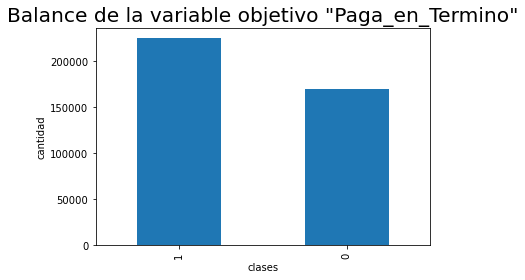

In [34]:
# Grafico
df_4_parsed['paga_en_termino'].value_counts().plot(kind='bar')
# Seteos del gráfico
plt.style.use('fivethirtyeight')
plt.xlabel('clases')
plt.ylabel ('cantidad')
plt.title('Balance de la variable objetivo "Paga_en_Termino"')

## Análisis de variables  

In [35]:
df_4_parsed.columns

Index(['paga_en_termino', 'total_cuotas', 'refinanciado', 'total_prestamo',
       'porcentaje_de_cuota_sobre_prestamo', 'fecha_pago', 'pago',
       'vencimiento', 'numero_cuota', 'porcentaje_de_cuotas_faltantes',
       'numero_prestamo', 'tipo_prestamo', 'dni', 'genero', 'edad'],
      dtype='object')

In [36]:
columns_data = ['total_cuotas', 'fecha_pago', 'numero_cuota', 'refinanciado', 'tipo_prestamo', 'pago', 'vencimiento',
                'total_prestamo','porcentaje_de_cuota_sobre_prestamo', 'paga_en_termino', 'porcentaje_de_cuotas_faltantes',  
               'genero', 'edad']

In [37]:
df_4_parsed.describe(include='all')

,paga_en_termino,total_cuotas,refinanciado,total_prestamo,porcentaje_de_cuota_sobre_prestamo,fecha_pago,pago,vencimiento,numero_cuota,porcentaje_de_cuotas_faltantes,numero_prestamo,tipo_prestamo,dni,genero,edad
count,"395,516.00","395,516.00","395,516.00","395,516.00","395,516.00",395516,"395,516.00",395516,"395,516.00","395,516.00","395,516.00","395,516.00","395,516.00","395,516.00","395,516.00"
unique,nan,nan,nan,nan,nan,1722,nan,920,nan,nan,nan,nan,nan,nan,nan
top,nan,nan,nan,nan,nan,2018-01-22 00:00:00,nan,2018-11-20 00:00:00,nan,nan,nan,nan,nan,nan,nan
freq,nan,nan,nan,nan,nan,2062,nan,6413,nan,nan,nan,nan,nan,nan,nan
first,nan,nan,nan,nan,nan,2015-01-02 00:00:00,nan,1997-09-22 00:00:00,nan,nan,nan,nan,nan,nan,nan
last,nan,nan,nan,nan,nan,2019-12-31 00:00:00,nan,2025-11-20 00:00:00,nan,nan,nan,nan,nan,nan,nan
mean,0.57,277.12,0.02,"207,312.16",0.75,NaN,"5,613.99",NaN,76.52,0.69,"7,231,047.59",738.07,"28,548,291.04",0.54,54.06
std,0.50,115.46,0.14,"439,371.30",4.73,NaN,"122,692.01",NaN,55.64,0.22,"4,739,496.28",334.21,"27,983,733.44",0.50,15.49
min,0.00,1.00,0.00,94.74,0.00,NaN,1.01,NaN,1.00,0.00,"107,059.00",1.00,9.00,0.00,3.00
25%,0.00,188.00,0.00,"20,001.68",0.23,NaN,58.04,NaN,27.00,0.59,"1,093,507.00",480.00,"12,131,738.00",0.00,43.00


In [38]:
df_4_parsed.pago

3           114.18
4         1,321.87
5        13,788.69
7        14,285.39
10        1,705.31
            ...   
575911    2,234.42
575912    2,234.42
575913    2,234.42
575914    2,234.42
575915    2,234.42
Name: pago, Length: 395516, dtype: float64

<Figure size 432x288 with 0 Axes>

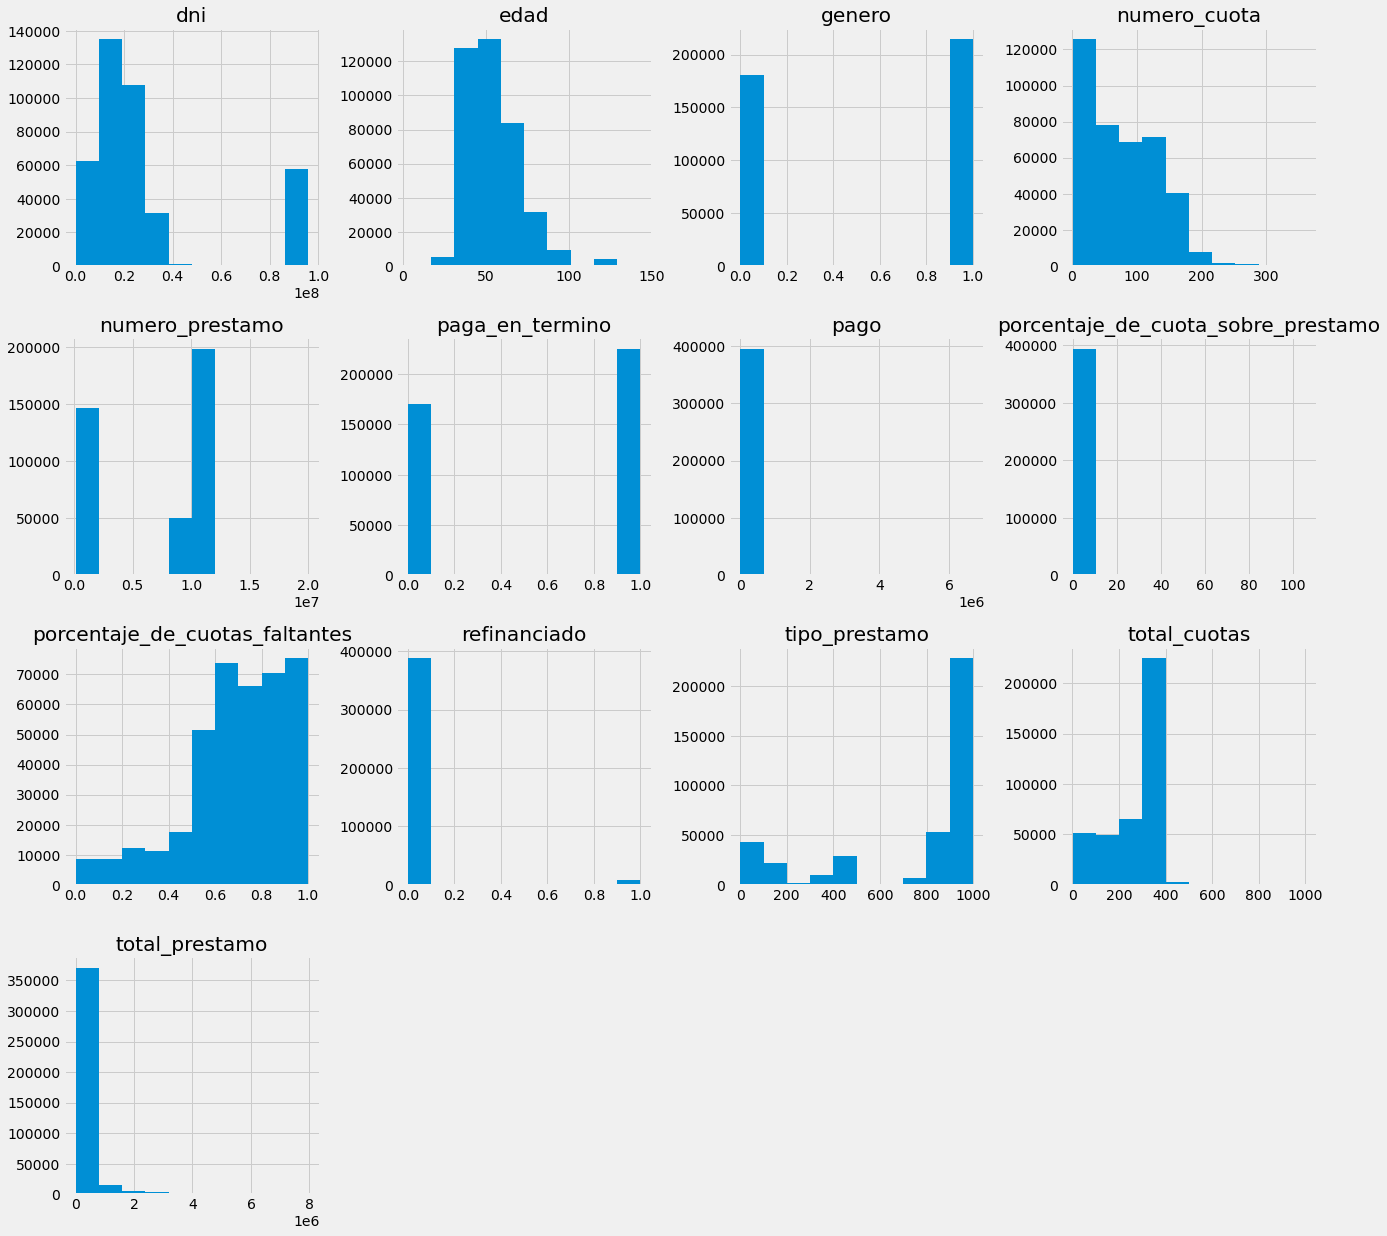

In [39]:
f = plt.figure() 
df_4_parsed.hist(figsize=(20,20))
plt.ticklabel_format(style='plain', axis='x')
plt.show()

### Total cuotas

<AxesSubplot:>

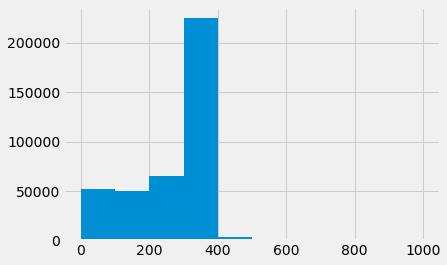

In [40]:
df_4_parsed['total_cuotas'].hist()

In [41]:
df_4_parsed['total_cuotas'].describe()

count   395,516.00
mean        277.12
std         115.46
min           1.00
25%         188.00
50%         360.00
75%         360.00
max         999.00
Name: total_cuotas, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1d7b73d6490>,
 'caps': [<matplotlib.lines.Line2D at 0x1d7b73d6b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d7ac58dc40>],
 'medians': [<matplotlib.lines.Line2D at 0x1d7b73e5220>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d7b73e5550>],
 'means': []}

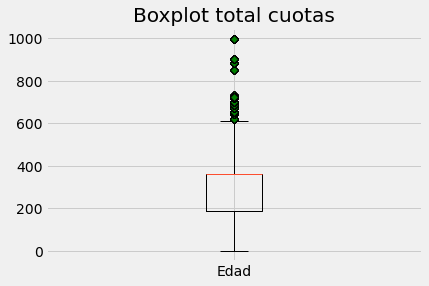

In [42]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot total cuotas')
ax.boxplot(df_4_parsed['total_cuotas'], flierprops=green_diamond, labels=["Edad"])

### Total prestamo

<AxesSubplot:>

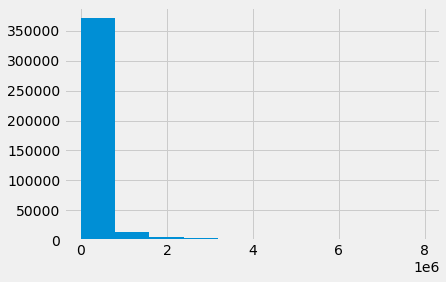

In [43]:
df_4_parsed['total_prestamo'].hist()

In [44]:
pd.options.display.float_format = '{:.1f}'.format
df_4_parsed['total_prestamo'].describe()

count    395516.0
mean     207312.2
std      439371.3
min          94.7
25%       20001.7
50%       66940.0
75%      152827.9
max     7951994.8
Name: total_prestamo, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1d7b74a7970>,
 'caps': [<matplotlib.lines.Line2D at 0x1d7b74b3070>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d7b74a75e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d7b74b3730>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d7b74b3a60>],
 'means': []}

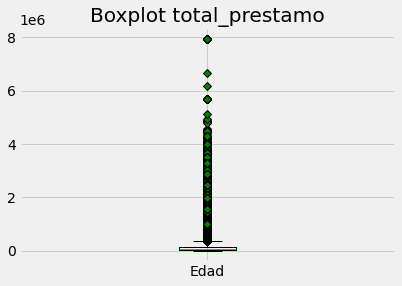

In [45]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot total_prestamo')
ax.boxplot(df_4_parsed['total_prestamo'], flierprops=green_diamond, labels=["Edad"])

[]

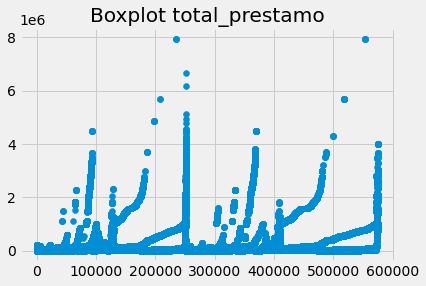

In [46]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
# ax.(figsize=(8, 8))
ax.set_title('Boxplot total_prestamo')
ax.ticklabel_format(useOffset=False)
ax.scatter(y= df_4_parsed['total_prestamo'], x=df_4_parsed['total_prestamo'].index)
ax.ticklabel_format(useOffset=False)
plt.plot()

------------------
----

In [47]:
from pyod.models.knn import KNN
import pandas as pd
 
edades = np.array([22,22,23,23,23,23,26,27,27,28,30,30,30,30,31,32,33,34,80])
edad_unique, counts = np.unique(edades, return_counts=True)
salario_anual_miles = np.array([16,20,15,21,19,17,33,22,31,32,56,30,22,31,30,16,2,22,23])
compras_mes = np.array([1,2,1,20,1,0,3,2,3,0,5,3,2,1,0,1,2,2,2])


X = pd.DataFrame(data={'edad':edades,'salario':salario_anual_miles, 'compras':compras_mes})
X

,edad,salario,compras
0,22,16,1
1,22,20,2
2,23,15,1
3,23,21,20
4,23,19,1
5,23,17,0
6,26,33,3
7,27,22,2
8,27,31,3
9,28,32,0


In [48]:
clf = KNN(contamination=0.18)
clf.fit(X)
y_pred = clf.predict(X)
X[y_pred == 1]

,edad,salario,compras
3,23,21,20
10,30,56,5
16,33,2,2
18,80,23,2


--------
-------

## Distribución de prestamos entre mujeres, hombres y edades 

In [49]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 3 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   paga_en_termino                     395516 non-null  int64         
 1   total_cuotas                        395516 non-null  int64         
 2   refinanciado                        395516 non-null  int64         
 3   total_prestamo                      395516 non-null  float64       
 4   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64       
 5   fecha_pago                          395516 non-null  datetime64[ns]
 6   pago                                395516 non-null  float64       
 7   vencimiento                         395516 non-null  datetime64[ns]
 8   numero_cuota                        395516 non-null  int64         
 9   porcentaje_de_cuotas_faltantes      395516 non-null  float64       
 10  numero_p

In [50]:
df_prestamos = df_4_parsed[['numero_prestamo', 'edad', 'genero']]
df_prestamos = df_prestamos.drop_duplicates()
df_prestamos.groupby(['genero','edad']).count().reset_index()['numero_prestamo'].sum()

10386

### Corr 

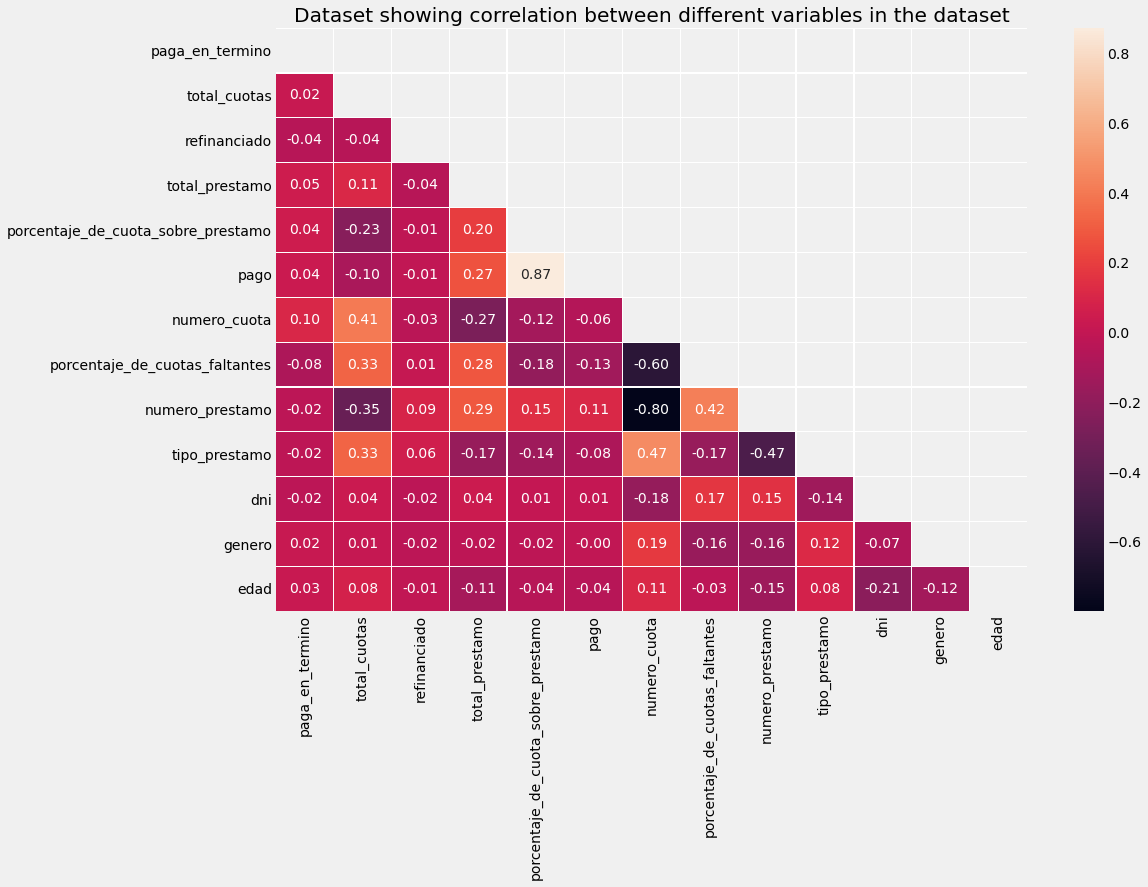

In [51]:
corr = df_4_parsed.corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.2, mask=mask)
plt.title('Dataset showing correlation between different variables in the dataset')
plt.show()

In [52]:
price_range_corr =  corr.paga_en_termino.sort_values(ascending = False)
price_range_corr_top = price_range_corr.head(10)
price_range_corr_bottom = price_range_corr.tail(10)
print ('top corr: \n{} \n\nbottom corr: \n{}'.format(price_range_corr_top, price_range_corr_bottom))

top corr: 
paga_en_termino                       1.0
numero_cuota                          0.1
total_prestamo                        0.0
porcentaje_de_cuota_sobre_prestamo    0.0
pago                                  0.0
edad                                  0.0
genero                                0.0
total_cuotas                          0.0
tipo_prestamo                        -0.0
dni                                  -0.0
Name: paga_en_termino, dtype: float64 

bottom corr: 
porcentaje_de_cuota_sobre_prestamo    0.0
pago                                  0.0
edad                                  0.0
genero                                0.0
total_cuotas                          0.0
tipo_prestamo                        -0.0
dni                                  -0.0
numero_prestamo                      -0.0
refinanciado                         -0.0
porcentaje_de_cuotas_faltantes       -0.1
Name: paga_en_termino, dtype: float64


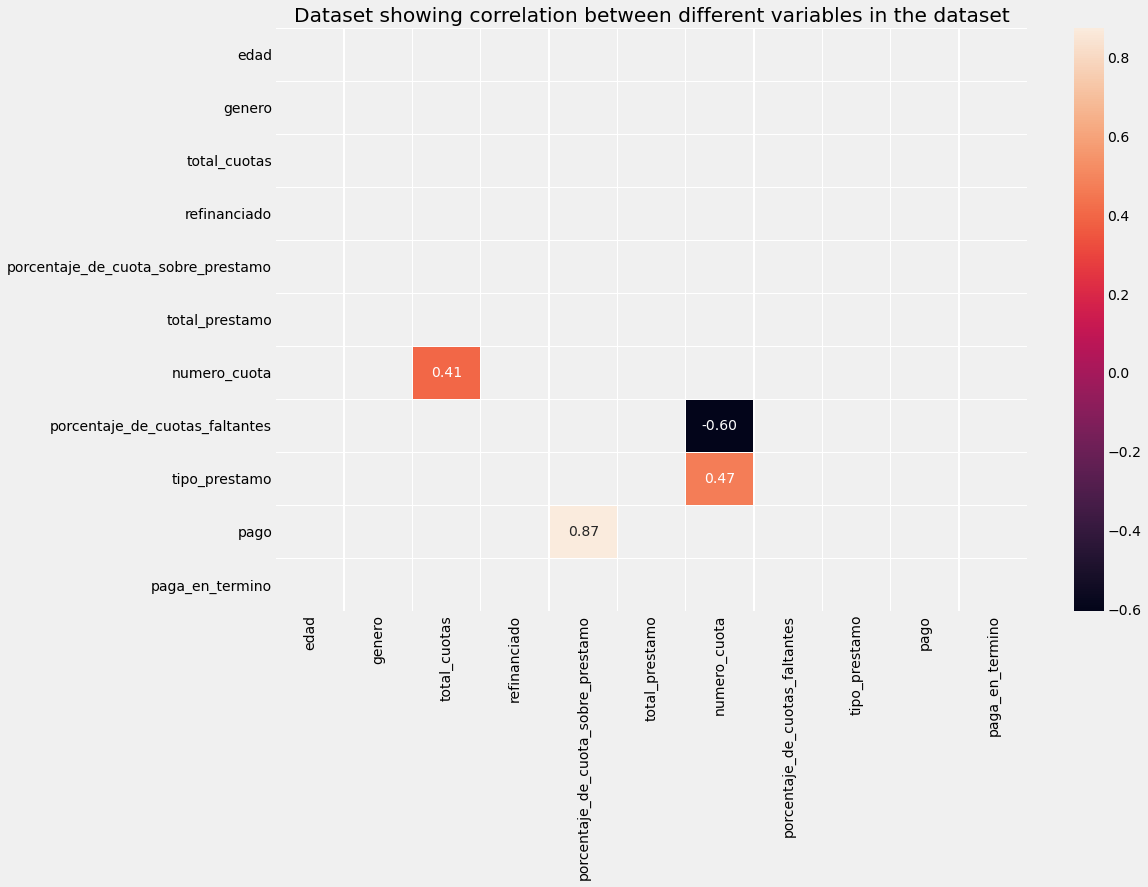

In [53]:
columns_data_corr = list(set(columns_data)&set(corr.columns))
corr_filter = corr[(corr>0.4) | (corr<-0.4)][columns_data_corr].copy()
corr_filter = corr_filter.filter(items = columns_data_corr, axis=0)
mask = np.triu(np.ones_like(corr_filter))
corr_filter.shape

plt.figure(figsize=(15,10))
sns.heatmap(corr_filter, annot=True, fmt='.2f', linewidths=.2,mask=mask)
plt.title('Dataset showing correlation between different variables in the dataset')
plt.show()

### Limpio los outliers principales  sobre el total de prestamo

In [54]:
df_4_parsed['total_prestamo']

3            108.2
4           1311.8
5          13777.7
7          14274.5
10          1695.2
            ...   
575911   1973529.5
575912   1973529.5
575913   1973529.5
575914   1973529.5
575915   1973529.5
Name: total_prestamo, Length: 395516, dtype: float64

In [55]:
Q1 = df_4_parsed['total_prestamo'].quantile(0.25)
Q3 = df_4_parsed['total_prestamo'].quantile(0.75)
IQR = Q3 - Q1
IQR

132826.25

In [56]:
from scipy import stats
z = np.abs(stats.zscore(df_4_parsed['total_prestamo']))
z

array([0.4715926 , 0.4688532 , 0.4404809 , ..., 4.01987927, 4.01987927,
       4.01987927])

In [57]:
# Se toman los prestamos con outliers
index_no_outlier = df_4_parsed['total_prestamo'][(z < 3)].index

In [58]:
# Se filtran los prestamos sin outliers
prestamos_sin_outlier = df.filter(items = index_no_outlier, axis=0)['numero_prestamo'].unique()

In [59]:
# Se crea un nuevo dataset sin outliers de numero de prestamo
df_5_sin_outlier = df_4_parsed[df_4_parsed['numero_prestamo'].isin(prestamos_sin_outlier)].copy()

## FILTRADO DE COLUMNA PARA EL MODELADO 

In [60]:
columns_data

['total_cuotas',
 'fecha_pago',
 'numero_cuota',
 'refinanciado',
 'tipo_prestamo',
 'pago',
 'vencimiento',
 'total_prestamo',
 'porcentaje_de_cuota_sobre_prestamo',
 'paga_en_termino',
 'porcentaje_de_cuotas_faltantes',
 'genero',
 'edad']

In [61]:
columns_model_no_time = list(set(columns_data) - {'fecha_pago', 'pago', 'vencimiento'})

## MODELADO 

In [62]:
from sklearn.model_selection import train_test_split

### Sin genero

In [63]:
y = df_5_sin_outlier['paga_en_termino']
X = df_5_sin_outlier[list(set(columns_model_no_time)-{'paga_en_termino'})]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [65]:
%%time 
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

Wall time: 42.6 s


In [66]:
%%time 
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8841613163526646
Wall time: 12 ms


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [68]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

C:\Users\Fran\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 59%|██████████████████████████████████▌                        | 17/29 [06:09<02:15, 11.27s/it]

In [ ]:
models.sort_values(by=[])